[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/XANESNN/blob/main/e3nn-xanes.ipynb)

# Predicting K-edge XANES with E(3)NN (Copy)

## Colab Setup

- Go to Runtime > Change runtime type, and select GPU.
- Clone the GitHub repository to access the tutorial files:

In [ ]:
!git clone https://github.com/ninarina12/XANESNN.git
%cd XANESNN

Cloning into 'XANESNN'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 29 (delta 11), reused 26 (delta 8), pack-reused 0
Receiving objects: 100% (29/29), 8.57 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/XANESNN


- Install the relevant packages:

In [ ]:
!pip uninstall torch -y
!pip install torch==2.2
!pip install ase pymatgen cmcrameri e3nn
!pip install torch-scatter torch-cluster torch-sparse torch-spline-conv -f https://pytorch-geometric.com/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-geometric

Found existing installation: torch 2.3.1+cu121
Uninstalling torch-2.3.1+cu121:
  Successfully uninstalled torch-2.3.1+cu121
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvt

## Package imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter

import keras
from keras import layers
from sklearn.model_selection import train_test_split

from ase import Atom
from ase.data import atomic_masses

from tqdm import tqdm
from utils.data import XANES, Process, bar_format
from utils.e3nn import Network

default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
#device = "cuda:0"
device = "cuda:0" if torch.cuda.is_available else "cpu"

In [ ]:
if not os.path.exists('images/'):
    os.makedirs('images/')

if not os.path.exists('models/'):
    os.makedirs('models/')

## Load and process data

In [ ]:
# Load data
data_file = 'data/Ni_K_XANES_averaged_simplified.json'
#full_data_file = 'data/Ni_K_XANES_averaged_full.json'
xanes = XANES()
xanes.load_data(data_file)
xanes.data

Number of samples: 2842


,structure,spectrum,formula_pretty
0,"[[5.543865 5.543865 5.543865] Ac, [1.847955 1....","{'x': [8335.8, 8336.263, 8336.678, 8337.044, 8...",Ac2NiIr
1,"[[5.7118125 5.7118125 5.7118125] Ac, [1.903937...","{'x': [8335.389, 8335.852, 8336.267, 8336.633,...",Ac2NiGe
2,"[[0. 0. 0.] Ni, [2.001977 2.001977 2.001977] A...","{'x': [8333.833, 8334.296, 8334.71, 8335.076, ...",NiAgF3
3,"[[ 1.504977 -0.86890074 3.95156027] Ni, [ 1...","{'x': [8334.728, 8335.191, 8335.606, 8335.971,...",Ni2Ag3O4
4,"[[0. 0. 0.] Ni, [1.82073964e+01 1.04518778e-16...","{'x': [8334.712, 8335.175, 8335.589, 8335.955,...",Ni(AgO)2
...,...,...,...
2837,"[[1.583357 1.583357 1.583357] Sc, [0. 0. 0.] Ni]","{'x': [8339.397, 8339.861, 8340.275, 8340.641,...",ScNi
2838,"[[ 2.657819 -1.5344954 3.2288895] Zr, [2.657...","{'x': [8338.461, 8338.925, 8339.339, 8339.705,...",ZrNi3
2839,"[[5.730893 0. 0. ] Zn, [2.8654465 2...","{'x': [8336.839, 8337.303, 8337.717, 8338.083,...",Zn(GaNi)3
2840,"[[-2.53717094 4.59002127 11.89782002] Li, [2....","{'x': [8334.66, 8335.123, 8335.538, 8335.903, ...",Li2Ni4OF8


In [ ]:
#Removing  x outliers
outliers = []
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['x']) < 8000:
    outliers += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
outliers

['Li2Ni(CO3)2',
 'Li2Ni(CO3)2',
 'CaNi2O5',
 'Li2Fe3NiO8',
 'CaNi2O5',
 'LiNi6O7',
 'Li2(NiO2)5',
 'Li6(NiO2)5',
 'Li2Ni(CO3)2',
 'Li2Ni(CO3)2',
 'Li15(NiO2)14']

In [ ]:
#Removing y outliers
#outliers = []
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['y']) < 0 or max(xanes.data['spectrum'][i]['y']) > 3:
    outliers += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))

In [ ]:
#Analyzing the repeats given in the data
Counter = np.zeros(len(xanes.data))
counter = 0
for i in range(len(xanes.data)):
   if 'wniwnd' in xanes.data['formula_pretty'][i]:
    print(xanes.data['formula_pretty'][i])

In [ ]:
xanes.data

,structure,spectrum,formula_pretty
0,"[[5.543865 5.543865 5.543865] Ac, [1.847955 1....","{'x': [8335.8, 8336.263, 8336.678, 8337.044, 8...",Ac2NiIr
1,"[[5.7118125 5.7118125 5.7118125] Ac, [1.903937...","{'x': [8335.389, 8335.852, 8336.267, 8336.633,...",Ac2NiGe
2,"[[0. 0. 0.] Ni, [2.001977 2.001977 2.001977] A...","{'x': [8333.833, 8334.296, 8334.71, 8335.076, ...",NiAgF3
3,"[[ 1.504977 -0.86890074 3.95156027] Ni, [ 1...","{'x': [8334.728, 8335.191, 8335.606, 8335.971,...",Ni2Ag3O4
4,[[1.49958153e-08 1.73156917e+00 5.14848807e+00...,"{'x': [8334.725, 8335.188, 8335.603, 8335.969,...",NiAgO2
...,...,...,...
2793,"[[1.583357 1.583357 1.583357] Sc, [0. 0. 0.] Ni]","{'x': [8339.397, 8339.861, 8340.275, 8340.641,...",ScNi
2794,"[[ 2.657819 -1.5344954 3.2288895] Zr, [2.657...","{'x': [8338.461, 8338.925, 8339.339, 8339.705,...",ZrNi3
2795,"[[5.730893 0. 0. ] Zn, [2.8654465 2...","{'x': [8336.839, 8337.303, 8337.717, 8338.083,...",Zn(GaNi)3
2796,"[[-2.53717094 4.59002127 11.89782002] Li, [2....","{'x': [8334.66, 8335.123, 8335.538, 8335.903, ...",Li2Ni4OF8


(array([5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 4.000e+00, 3.000e+00, 2.000e+00, 5.000e+00,
        5.000e+00, 2.801e+03]),
 array([-11.2026   , -10.6254661, -10.0483322,  -9.4711983,  -8.8940644,
         -8.3169305,  -7.7397966,  -7.1626627,  -6.5855288,  -6.0083949,
         -5.431261 ,  -4.8541271,  -4.2769932,  -3.6998593,  -3.1227254,
         -2.5455915,  -1.9684576,  -1.3913237,  -0.8141898,  -0.2370559,
          0.340078 ]),
 <BarContainer object of 20 artists>)

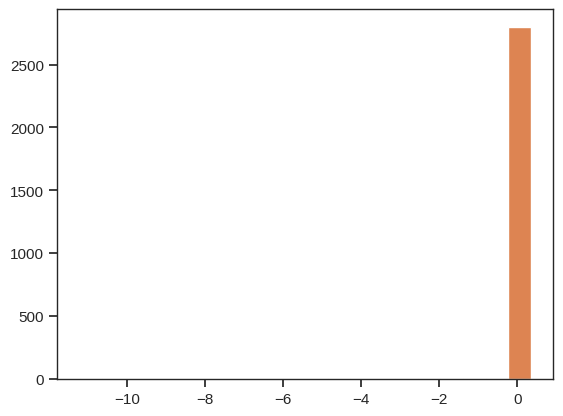

In [ ]:
#Diving into the data to see what we have in terms of max and mins
finder = 0
minx = np.zeros(len(xanes.data))
maxx = np.zeros(len(xanes.data))
counter = 0
for i in xanes.data.index:
  y = xanes.data['spectrum'][i]['y']
  if min(y) < 0:
    x = 1
  maxx[counter] = max(y)
  minx[counter] = min(y)
  counter += 1
plt.hist(minx,20)
#plt.hist(maxx,20)
x_norm = xanes.data['spectrum'][89]['x']
y_out = xanes.data['spectrum'][4]['y']
#plt.plot(x_norm,y_out)
plt.hist(minx,20)

In [ ]:
#Designing the function that can turn formulas into vectors
def element_to_vector(element):
  #Only using the first 100 elements since none past that point are in the sample data
  elements = ('H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti',
              'V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
              'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb',
              'Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
              'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm')
  vector = np.zeros(len(elements))
  counter = 0
  for i in range(len(elements)):
    if element == elements[i]:
      vector[i] = 1
      return vector
    else:
      counter += 1
  if counter ==len(elements):
    raise Exception('Element not found')

def formula_to_vector(formula):
  #This assumes parenthesis only appear once in the entire formula
  upper = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  lower = 'abcdefghijklmnopqrstuvwxyz'
  length = len(formula)
  vector = np.zeros(100)
  parenthesis = 0
  for i in range(length):
    #Every element starts with an uppercase so we use this method
    if formula[i] != ')':
      if formula[i] != '(':
        if parenthesis == 0:
          if formula[i] in upper:
            if length - 1 > i:
              if formula[i+1] in lower:
                element = formula[i] + formula[i+1]
              else:
                element = formula[i]
            else:
              element = formula[i]
          else:
            continue
        else:
          continue
      else:
        counter = 0
        parenthesis += 1
        vector_mini = formula_to_vector(formula[i+1:])
        for j in range(10,100):
          if ")" + str(j) in formula:
            vector += vector_mini*j
          else:
            counter += 1
        #Then single digits
        if counter == 90:
          for j in range(10):
            if ')' + str(j) in formula:
              vector += vector_mini*j
            else:
              counter += 1
        #Then it just assumes it has no number in front of it
        if counter == 100:
          vector += vector_mini
        continue
    else:
      if parenthesis==0:
        return vector
      else:
        parenthesis -= 1
        continue
    #We know that no element appears in a chemical more than 53 times in our data set
    #But we generalize to 100
    counter = 0
    #This checks for double digits first
    for j in range(10,100):
      if element + str(j) in formula:
        vector += element_to_vector(element)*j
      else:
        counter += 1
    #Then single digits
    if counter == 90:
      for j in range(10):
        if element + str(j) in formula:
          vector += element_to_vector(element)*j
        else:
          counter += 1
    #Then it just assumes it has no number in front of it
    if counter == 100:
      vector += element_to_vector(element)
  return vector

formula_to_vector('He5(H7CV11Es10)2Fm13')

array([14.,  5.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 22.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., 20., 13.])

In [ ]:
# TO DO: Interpolate XANES data to uniform energy bins (Distorted to lower values)
xmin = 8341
xmax = 8388
x_new = np.linspace(xmin,xmax,100)
for i in xanes.data.index:
  x_old = xanes.data['spectrum'][i]['x']
  y_old = xanes.data['spectrum'][i]['y']
  y_new = np.interp(x_new,x_old,y_old)
  xanes.data['spectrum'][i]['x'] = x_new
  xanes.data['spectrum'][i]['y'] = y_new
#plt.plot(x_old,y_old)
#plt.plot(x_new,y_new)
xanes.data

,structure,spectrum,formula_pretty
0,"[[5.543865 5.543865 5.543865] Ac, [1.847955 1....","{'x': [8341.0, 8341.474747474747, 8341.9494949...",Ac2NiIr
1,"[[5.7118125 5.7118125 5.7118125] Ac, [1.903937...","{'x': [8341.0, 8341.474747474747, 8341.9494949...",Ac2NiGe
2,"[[0. 0. 0.] Ni, [2.001977 2.001977 2.001977] A...","{'x': [8341.0, 8341.474747474747, 8341.9494949...",NiAgF3
3,"[[ 1.504977 -0.86890074 3.95156027] Ni, [ 1...","{'x': [8341.0, 8341.474747474747, 8341.9494949...",Ni2Ag3O4
4,[[1.49958153e-08 1.73156917e+00 5.14848807e+00...,"{'x': [8341.0, 8341.474747474747, 8341.9494949...",NiAgO2
...,...,...,...
2793,"[[1.583357 1.583357 1.583357] Sc, [0. 0. 0.] Ni]","{'x': [8341.0, 8341.474747474747, 8341.9494949...",ScNi
2794,"[[ 2.657819 -1.5344954 3.2288895] Zr, [2.657...","{'x': [8341.0, 8341.474747474747, 8341.9494949...",ZrNi3
2795,"[[5.730893 0. 0. ] Zn, [2.8654465 2...","{'x': [8341.0, 8341.474747474747, 8341.9494949...",Zn(GaNi)3
2796,"[[-2.53717094 4.59002127 11.89782002] Li, [2....","{'x': [8341.0, 8341.474747474747, 8341.9494949...",Li2Ni4OF8


In [ ]:
#Estimating interpolation error
x_new = np.linspace(xmin,xmax,100)
loss = 0
for i in xanes.data.index:
  x_old = xanes.data['spectrum'][i]['x']
  y_old = xanes.data['spectrum'][i]['y']
  y_new = np.interp(x_new,x_old,y_old)
  y_est = np.interp(x_old,x_new,y_new)
  loss += np.linalg.norm(y_old-y_est)**2/(len(xanes.data)*100)
loss

0.0

100%|██████████| 2830/2830 [01:42<00:00, 27.61it/s] 


The minimum is 0.0
The 1st percentile is 0.004229991527363998
The 5th percentile is 0.00898134343474626
The 10th percentile is 0.013574849365687978
The 50th percentile is 0.049465359838094074


Text(0.5, 0, 'MSE')

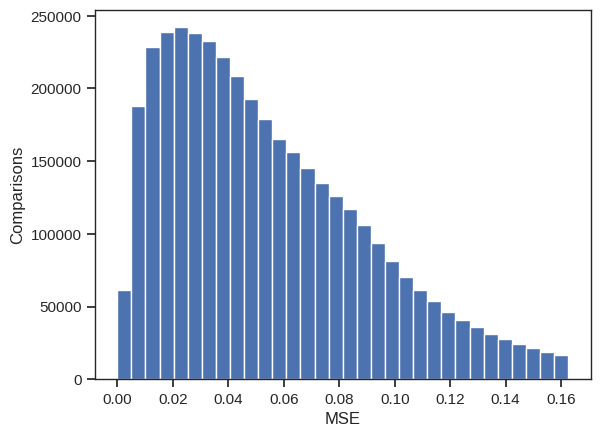

In [ ]:
#Calculating minimum distance in our dataset
length = len(xanes.data)
minimum = 1
mins = np.zeros(int(((length-1)**2 + length - 1)/2))
shift = 0
for i in tqdm(range(len(xanes.data)-1)):
  for j in range(i+1,len(xanes.data)):
    mins[shift] = np.linalg.norm(xanes.data['spectrum'][i]['y']-xanes.data['spectrum'][j]['y'])**2/100
    shift += 1
print("The minimum is", min(mins))
print("The 1st percentile is", np.percentile(mins,1))
print("The 5th percentile is", np.percentile(mins,5))
print("The 10th percentile is", np.percentile(mins,10))
print("The 50th percentile is", np.percentile(mins,50))
#print(xanes.data['formula_pretty'][closesti],xanes.data['formula_pretty'][closestj])
plt.hist(mins,32, (0,np.percentile(mins,95)))
plt.ylabel("Comparisons")
plt.xlabel("MSE")
#plt.plot(xanes.data['spectrum'][closesti]['x'],xanes.data['spectrum'][closesti]['y'])
#plt.plot(xanes.data['spectrum'][closestj]['x'],xanes.data['spectrum'][closestj]['y'])

0.0294179716025797

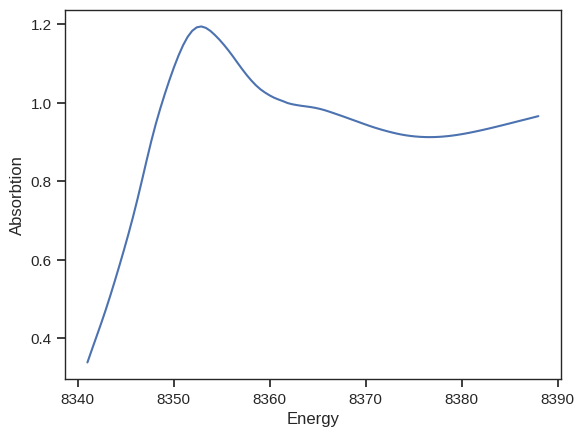

In [ ]:
means = np.zeros(100)
for i in xanes.data.index:
  means += xanes.data['spectrum'][i]['y']
means = means/len(xanes.data)
plt.plot(x_new,means)
plt.ylabel("Absorbtion")
plt.xlabel("Energy")
loss = 0
for i in range(len(xanes.data)):
  loss += np.mean((xanes.data['spectrum'][i]['y']-means)**2)/len(xanes.data)
loss

In [ ]:
#Creating the inputs for our alternative model
input = np.zeros((len(xanes.data),100))
output = np.zeros((len(xanes.data),100))
shifter = 0
for i in xanes.data.index:
    input[shifter] = formula_to_vector(xanes.data['formula_pretty'][i])
    output[shifter] = xanes.data['spectrum'][i]['y']
    shifter += 1
len(input)

2798

In [ ]:
#Dividing up the train and test sets
X_train, x_test, Y_train, y_test = train_test_split(
    input, output, test_size=0.25)
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, test_size=0.25)


In [ ]:
#Creating the alternative model
inputs = keras.Input(shape=(100,), name="formula")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dropout(.1)(x)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(100, activation="relu", name="Sprectrum")(x)

mymodel = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Fitting the model to the data
mymodel.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=['accuracy'],
)
history = mymodel.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(x_val, y_val),
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.0229 - loss: 0.7086 - val_accuracy: 0.0190 - val_loss: 0.5364
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0243 - loss: 0.4703 - val_accuracy: 0.0419 - val_loss: 0.3687
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0305 - loss: 0.3319 - val_accuracy: 0.0362 - val_loss: 0.2735
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0235 - loss: 0.2279 - val_accuracy: 0.0305 - val_loss: 0.2102
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0234 - loss: 0.1526 - val_accuracy: 0.0457 - val_loss: 0.1590
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0303 - loss: 0.1266 - val_accuracy: 0.0400 - val_loss: 0.1156
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0324 - loss: 0.0818 - val_accuracy: 0.0514 - val_loss: 0.0833
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0341 - loss: 0.0646 - val_accuracy: 0.0438 -

In [ ]:
#Looking at the training history
# list all data in history
print(history.history.keys())
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim((0.001,.03))
plt.show()

AttributeError: 'list' object has no attribute 'history'

In [ ]:
#Evaluating the alternative model
mean_dif = 0
made_up = np.zeros((2,100))
for i in tqdm(xanes.data.index):
  made_up[:] = formula_to_vector(xanes.data['formula_pretty'][i])
  y_temp = mymodel.predict(made_up)[0]
  mean_dif += np.linalg.norm(y_temp-xanes.data['spectrum'][i]['y'])**2

mean_dif = mean_dif/len(xanes.data)
better = np.zeros(100)
worse = np.zeros(100)

for i in tqdm(xanes.data.index):
  made_up[:] = formula_to_vector(xanes.data['formula_pretty'][i])
  y_temp = c[0]
  if mean_dif < np.linalg.norm(y_temp-xanes.data['spectrum'][i]['y'])**2:
    better += made_up[0]
  else:
    worse += made_up[0]

print(better,worse)

  0%|          | 0/2798 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


  0%|          | 1/2798 [00:00<15:09,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|          | 3/2798 [00:00<06:01,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 5/2798 [00:00<04:16, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 7/2798 [00:00<03:38, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 9/2798 [00:00<03:21, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  0%|          | 11/2798 [00:00<03:12, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  0%|          | 13/2798 [00:01<03:00, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|          | 15/2798 [00:01<02:54, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  1%|          | 17/2798 [00:01<03:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 19/2798 [00:01<03:12, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


  1%|          | 21/2798 [00:01<03:28, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  1%|          | 23/2798 [00:01<04:49,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|          | 25/2798 [00:02<04:10, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 27/2798 [00:02<03:48, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 29/2798 [00:02<03:49, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  1%|          | 31/2798 [00:02<04:42,  9.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  1%|          | 33/2798 [00:02<05:07,  9.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|▏         | 35/2798 [00:03<04:31, 10.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  1%|▏         | 37/2798 [00:03<04:01, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▏         | 39/2798 [00:03<03:55, 11.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


  1%|▏         | 41/2798 [00:03<05:19,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 43/2798 [00:03<04:50,  9.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 45/2798 [00:04<04:20, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 47/2798 [00:04<03:50, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|▏         | 49/2798 [00:04<03:43, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 51/2798 [00:04<03:34, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 53/2798 [00:04<03:16, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 55/2798 [00:04<03:05, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  2%|▏         | 57/2798 [00:04<03:01, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


  2%|▏         | 58/2798 [00:04<03:50, 11.88it/s]


KeyboardInterrupt: 

In [ ]:
#Getting the average spectrum and checking error
elements = ('H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti',
              'V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
              'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb',
              'Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
              'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm')
mean = np.zeros(100)

for i in range(len(xanes.data)):
  mean += xanes.data['spectrum'][i]['y']
mean = mean/len(xanes.data)

for i in range(len(xanes.data)):
  loss += np.linalg.norm(mean-xanes.data['spectrum'][i]['y'])**2
loss = loss/(len(xanes.data)*100)

for i in range(100):
  worse[i] = int(worse[i])

print("We have an average mean loss of",loss)
print((better),worse)



NameError: name 'loss' is not defined

100%|██████████| 2798/2798 [00:01<00:00, 2360.57it/s]


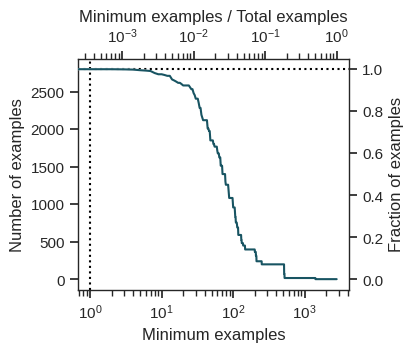

In [ ]:
# Enforce a minimum number of examples of each specie
species_min = 1

xanes.get_species_counts()
fig = xanes.plot_species_counts(species_min)
#xanes.set_species_counts(species_min)
#xanes.get_species_counts()
#xanes.savefig('images/species_counts.svg', bbox_inches='tight')

Average lattice parameter (a/b/c): 6.5854671410481185 / 6.992771865370876 / 8.61623002352931


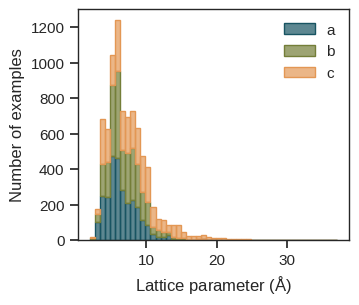

In [ ]:
# Lattice parameter statistics
xanes.get_lattice_parameters()
fig = xanes.plot_lattice_parameters(n_bins=50)
#fig.savefig('images/lattice_parameters.svg', bbox_inches='tight')

## Format input features

In [ ]:
# Get species
species = sorted(list(set(xanes.data['species'].sum())))
n_species = list(np.unique(xanes.data['species'].sum(), return_counts=True)[1])
Z_max = max([Atom(k).number for k in species])
print(Z_max)

94


In [ ]:
# One-hot encoding atom type and mass
type_encoding = {}
mass_specie = []

for Z in tqdm(range(1, Z_max + 1), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    mass_specie.append(atomic_masses[Z])

type_onehot = torch.eye(len(type_encoding))
mass_onehot = torch.diag(torch.tensor(mass_specie))

100%|██████████| 94/94 [00:00<00:00, 156702.93it/s]


In [ ]:
# Process data into input descriptors
process = Process(species, Z_max, type_encoding, type_onehot, mass_onehot, default_dtype)

r_max = 5.     # cutoff radius
tqdm.pandas(desc='Building data', bar_format=bar_format)
xanes.data['input'] = xanes.data.progress_apply(lambda x: process.build_data(x, r_max), axis=1)

Building data: 100%|██████████| 2798/2798 [02:32<00:00, 18.34it/s]


## Format training, validation, and test sets

Split train/dev ...


100%|██████████| 83/83 [00:00<00:00, 197.37it/s]


Split valid/test ...


100%|██████████| 83/83 [00:00<00:00, 251.33it/s]


Number of training examples: 1639
Number of validation examples: 542
Number of testing examples: 617
Total number of examples: 2798


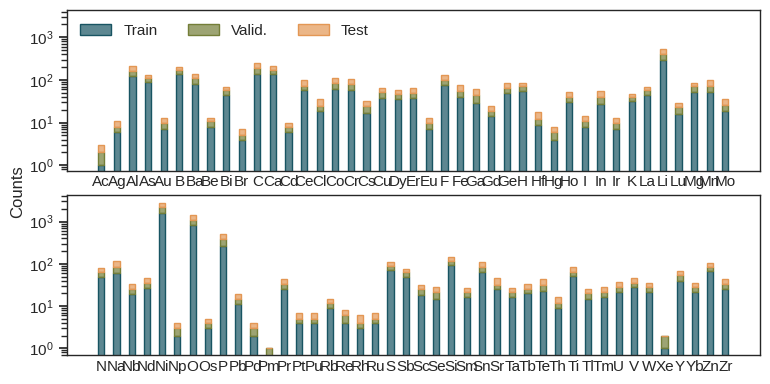

In [ ]:
# Train/valid/test split
test_size = 0.2
fig = process.train_valid_test_split(xanes.data, valid_size=test_size, test_size=test_size, plot=True)
#fig.savefig('images/train_valid_test_split.svg', bbox_inches='tight')

Average number of neighbors (train/valid/test): 43.448961358052266 / 43.66349938916791 / 42.99644046388793


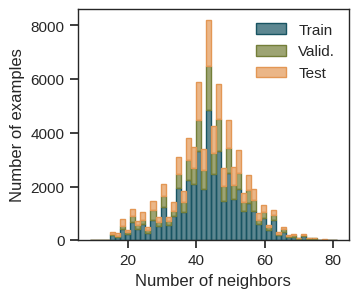

In [ ]:
# Calculate average number of neighbors
process.get_neighbors(xanes.data)
fig = process.plot_neighbors(n_bins=50)
print('Average number of neighbors (train/valid/test):', process.n_train.mean(), '/',
                                                         process.n_valid.mean(), '/',
                                                         process.n_test.mean())
#fig.savefig('images/num_neighbors.svg', bbox_inches='tight')

In [ ]:
# Format dataloaders
batch_size = 16
dataloader_train = tg.loader.DataLoader(xanes.data.iloc[process.idx_train]['input'].tolist(), batch_size=batch_size,
                                        shuffle=True)
dataloader_valid = tg.loader.DataLoader(xanes.data.iloc[process.idx_valid]['input'].tolist(), batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(xanes.data.iloc[process.idx_test]['input'].tolist(), batch_size=batch_size)

## Build neural network model

In [ ]:
class E3NN(Network):
    def __init__(self, in_dim, out_dim, emb_dim, num_layers, mul, lmax, max_radius, num_basis, radial_layers,
                 radial_neurons, num_neighbors):
        kwargs = {'reduce_output': False,
                  'irreps_in': str(emb_dim)+"x0e",
                  'irreps_out': str(out_dim)+"x0e",
                  'irreps_node_attr': str(emb_dim)+"x0e",
                  'layers': num_layers,
                  'mul': mul,
                  'lmax': lmax,
                  'max_radius': max_radius,
                  'number_of_basis': num_basis,
                  'radial_layers': radial_layers,
                  'radial_neurons': radial_neurons,
                  'num_neighbors': num_neighbors
                 }
        super().__init__(**kwargs)

        # definitions
        self.cmap = plt.get_cmap('plasma')
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.mul = mul
        self.lmax = lmax
        self.max_radius = max_radius
        self.num_basis = num_basis
        self.radial_layers = radial_layers
        self.radial_neurons = radial_neurons
        self.num_neighbors = num_neighbors

        self.model_name = 'e3nn-xanes_' + '_'.join(i + str(int(j)) for (i,j) in zip(
            ['emb', 'layers', 'mul', 'lmax', 'rmax', 'nbasis', 'rlayers', 'rneurons'],
            [emb_dim, num_layers, mul, lmax, max_radius, num_basis, radial_layers, radial_neurons]))

        # embedding
        self.emb_x = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.ReLU()
        )

        self.emb_z = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.Tanh()
        )


    def forward(self, data):
        data['x'] = self.emb_x(data['x_in'])
        data['z'] = self.emb_z(data['z_in'])
        x = super().forward(data)[0]

        # aggregate
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        y = torch_scatter.scatter_mean(x, batch, dim=0)
        return y


    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def loss(self, y_pred, y_true):
        return torch.mean((y_pred-y_true)**2)


    def checkpoint(self, dataloader, device):
        self.eval()

        loss_cum = 0.
        with torch.no_grad():
            for j, d in enumerate(dataloader):
                d.to(device)
                y_pred = self.forward(d)

                loss = self.loss(y_pred, d.y).cpu()
                loss_cum += loss.detach().item()

        return loss_cum/len(dataloader)


    def fit(self, opt, dataloader_train, dataloader_valid, history, s0, max_iter=10, device="cpu", scheduler=None):
        chkpt = 1

        for step in range(max_iter):
            self.train()

            loss_cum = 0.
            start_time = time.time()

            for j, d in enumerate(dataloader_train):
                d.to(device)
                y_pred = self.forward(d)

                loss = self.loss(y_pred, d.y).cpu()
                loss_cum += loss.detach().item()

                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"batch loss = {loss.data:.4e}", end="\r", flush=True)

                opt.zero_grad()
                loss.backward()
                opt.step()

            if scheduler is not None:
                scheduler.step()

            end_time = time.time()
            wall = end_time - start_time

            if (step+1)%chkpt == 0:
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"epoch loss = {loss_cum/len(dataloader_train):.4e}")

                loss_valid = self.checkpoint(dataloader_valid, device)
                loss_train = self.checkpoint(dataloader_train, device)

                history.append({
                    'step': step + s0,
                    'wall': wall,
                    'batch': {
                        'loss': loss.item(),
                    },
                    'valid': {
                        'loss': loss_valid,
                    },
                     'train': {
                         'loss': loss_train,
                     },
                })

                yield {
                    'history': history,
                    'state': self.state_dict(),
                    'optimizer': opt.state_dict(),
                    'scheduler': scheduler.state_dict() if scheduler else None
                }

In [ ]:
args_enn = {'in_dim': Z_max,
            'out_dim': xanes.data.iloc[0]['input'].y.shape[-1],
            'emb_dim': 64,
            'num_layers': 2,
            'mul': 32,
            'lmax': 2,
            'max_radius': r_max,
            'num_basis': 10,
            'radial_layers': 1,
            'radial_neurons': 100,
            'num_neighbors': process.n_train.mean(),
           }

enn = E3NN(**args_enn).to(device)
opt = torch.optim.Adam(enn.parameters(), lr=1e-3)
scheduler = None #torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

model_num = 0
model_path = 'models/' + enn.model_name + '_' + str(model_num) + '.torch'

print(model_path)
#print(enn)
print('Number of parameters:', enn.count_parameters())

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: Us

models/e3nn-xanes_emb64_layers2_mul32_lmax2_rmax5_nbasis10_rlayers1_rneurons100_0.torch
Number of parameters: 4974392


/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(


In [ ]:
fig = enn.visualize()

NameError: name 'enn' is not defined

## Train model

In [ ]:
resume = False

if resume:
    saved = torch.load(model_path, map_location=device)
    enn.load_state_dict(saved['state'])
    opt.load_state_dict(saved['optimizer'])
    try:
        scheduler.load_state_dict(saved['scheduler'])
    except:
        scheduler = None
    history = saved['history']
    s0 = history[-1]['step'] + 1

else:
    history = []
    s0 = 0

In [ ]:
# fit E3NN
for results in enn.fit(opt, dataloader_train, dataloader_valid, history, s0, max_iter=50, device=device,
                       scheduler=scheduler):
    with open(model_path, 'wb') as f:
        torch.save(results, f)

Iteration     1    batch   103 /   103   epoch loss = 6.4970e-01
Iteration     2    batch   103 /   103   epoch loss = 4.9344e-02
Iteration     3    batch   103 /   103   epoch loss = 2.6673e-02
Iteration     4    batch   103 /   103   epoch loss = 2.1655e-02
Iteration     5    batch   103 /   103   epoch loss = 1.8933e-02
Iteration     6    batch   103 /   103   epoch loss = 1.6834e-02
Iteration     7    batch   103 /   103   epoch loss = 1.5195e-02
Iteration     8    batch   103 /   103   epoch loss = 1.3815e-02
Iteration     9    batch   103 /   103   epoch loss = 1.2810e-02
Iteration    10    batch   103 /   103   epoch loss = 1.2023e-02
Iteration    11    batch   103 /   103   epoch loss = 1.1393e-02
Iteration    12    batch   103 /   103   epoch loss = 1.0686e-02
Iteration    13    batch   103 /   103   epoch loss = 1.0110e-02
Iteration    14    batch   103 /   103   epoch loss = 9.7876e-03
Iteration    15    batch   103 /   103   epoch loss = 9.3423e-03
Iteration    16    batch 

In [ ]:
if not os.path.exists('images/' + enn.model_name + '_' + str(model_num)):
    os.makedirs('images/' + enn.model_name + '_' + str(model_num))

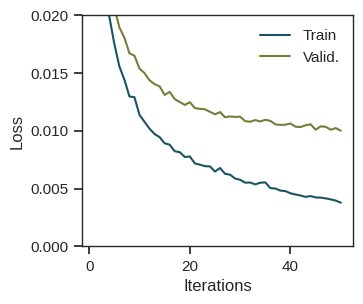

In [ ]:
saved = torch.load(model_path, map_location=device)
history = saved['history']

steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(steps, loss_train, label='Train', color=process.colors['Train'])
ax.plot(steps, loss_valid, label='Valid.', color=process.colors['Valid.'])

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_ylim(0,.02)
ax.legend(frameon=False)
#ax.set_yscale('log')
#fig.savefig('images/' + enn.model_name + '_' + str(model_num) + '/loss.svg', bbox_inches='tight')

## Evaluate model

In [ ]:
#Comparing some
test_y_true = np.zeros((batch_size*len(dataloader_test),100))
test_y_pred = np.zeros((batch_size*len(dataloader_test),100))
current = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
  for j,d in enumerate(dataloader_test):
    inputs = d.to(device)  # Adjust 'input' according to your data keys
    targets = d['y'].to(device)

    test_y_pred[current:current+len(d.y)] = enn(d).cpu().numpy()
    test_y_true[current:current+len(d.y)] = targets.cpu().numpy()
    current += len(d.y)

In [ ]:
#Smoothing out the predictions through convolution
for i in range(len(test_y_pred)):
  temp = np.append(test_y_pred[i][0],test_y_pred[i])
  temp = np.append(temp,test_y_pred[i][len(test_y_pred[i])-1])
  temp = np.convolve(temp,[.25,.5,.25])
  temp = np.delete(temp,len(temp)-1)
  temp = np.delete(temp,len(temp)-1)
  temp = np.delete(temp,0)
  test_y_pred[i] = np.delete(temp,0)

In [ ]:
#Getting the cosine similarity
print('The Cosine similarity is')
print(np.sum(test_y_pred*test_y_true)/((np.sum(test_y_pred**2))**(1/2)*(np.sum(test_y_true**2))**(1/2)))

The Cosine similarity is
0.9950793612772905


In [ ]:
#Find the average error:
error = np.zeros(len(test_y_pred))
for i in range(len(test_y_pred)):
  error[i] = np.mean((test_y_pred[i]-test_y_true[i])**2)
  #if np.mean((test_y_pred[i]-test_y_true[i])**2) == 7.898989:
    #plt.plot(x_new,test_y_pred[i])
    #plt.plot(x_new,test_y_true[i])
print(np.percentile(error,25))
print(np.percentile(error,50))
print(np.percentile(error,75))
print(np.percentile(error,95))

0.0018736279524084194
0.003249887642045407
0.006791062568006788
0.023685838469291426


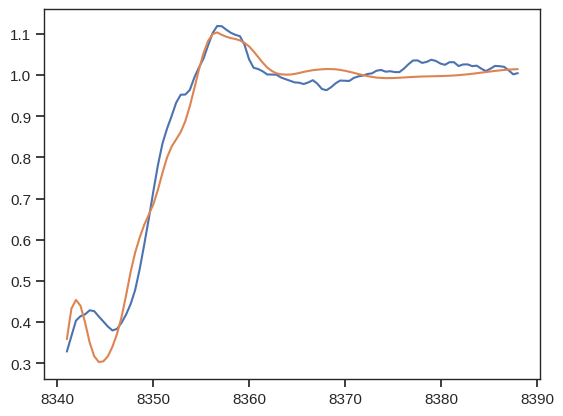

In [ ]:

plt.plot(x_new,test_y_pred[120])
plt.plot(x_new,test_y_true[120])
#print(max(error))
#print(min(error[:len(error)-10]))

(array([24., 89., 96., 74., 57., 37., 31., 31., 24., 23., 13.,  8.,  9.,
         9., 12.,  5.,  5., 10.,  4.,  6.,  3.,  1.,  2.,  2.,  2.,  1.,
         3.,  3.,  4.,  1.,  3.,  0.]),
 array([0.        , 0.00074018, 0.00148036, 0.00222055, 0.00296073,
        0.00370091, 0.00444109, 0.00518128, 0.00592146, 0.00666164,
        0.00740182, 0.00814201, 0.00888219, 0.00962237, 0.01036255,
        0.01110274, 0.01184292, 0.0125831 , 0.01332328, 0.01406347,
        0.01480365, 0.01554383, 0.01628401, 0.0170242 , 0.01776438,
        0.01850456, 0.01924474, 0.01998493, 0.02072511, 0.02146529,
        0.02220547, 0.02294566, 0.02368584]),
 <BarContainer object of 32 artists>)

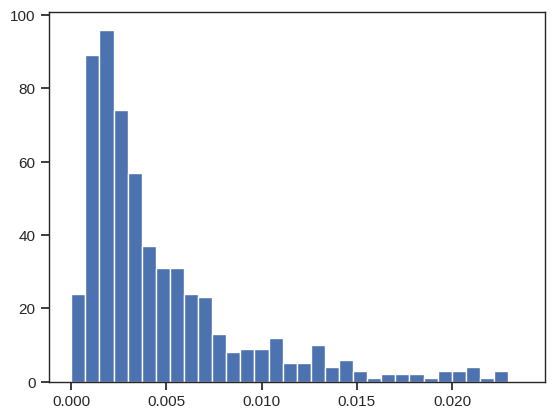

In [ ]:
plt.hist(error,32,(0,np.percentile(error,95)))